In [1]:
%matplotlib notebook
import ipympl
import ROOT as r
%jsroot on
r.PyConfig.DisableRootLogon = True
r.PyConfig.IgnoreCommandLineOptions = False
import numpy as np
from array import array
import matplotlib.pyplot as plt
import pandas as pd
from array import array
import scipy.optimize as opt
from glob import glob
import time
from multiprocessing import Pool as mp
import itertools
import itertools
import multiprocessing
from functools import partial

Welcome to JupyROOT 6.28/06


In [2]:
PD_30 = 0.3
PD_slope = 0.2/90

PA_30 = 50
PA_slope = 20/90

In [3]:
def polfrac_model(E,PD30,beta):
    PD = beta*(E-30) + PD30
    if not np.isscalar(PD):
        for i in range(len(PD)):
            if PD[i] < 0:
                PD[i] = 0
            elif PD[i] > 1:
                PD[i] = 1
    else:
        if PD < 0:
            PD = 0
        elif PD > 1:
            PD = 1
    return PD

def polang_model(E,PA30,gamma):
    return gamma*(E-30) + PA30

full_likelihood_tensor = np.load(f"/home/jacob/xlc_sim_outputs/notebook_outputs/likelihood_tensor_0_360.npy")
full_likelihood_tensor = full_likelihood_tensor
if full_likelihood_tensor[:,:,int(np.ceil(0*100)),:].max() < 1:
    full_likelihood_tensor[:,:,int(np.ceil(0*100)),:] = -np.log(full_likelihood_tensor[:,:,int(np.ceil(0*100)),:])
full_likelihood_tensor = np.exp(-full_likelihood_tensor)
global full_likelihood_tensor

In [4]:
from multiprocessing import Pool as mp
import itertools
import itertools
import multiprocessing


def likelihood(par,data_numb):
    global data_set
    i = data_numb
    if True:
        if (data_set['horizontal_pixel'][i] < 32):# & (data_set['pixel_row'][i] < 31):
            
            horizontal_pixel = data_set['horizontal_pixel'][i]

            #Get the rotation angle for each event
            rotation_angle = int(data_set['rotationangle'][i])
            if rotation_angle ==360:
                rotation_angle = 0
            
            angle = polang_model(data_set['energy'][i],par[0],par[1])
            PD = polfrac_model(data_set['energy'][i],par[2],par[3])
            #angle = par[0]
            #PD = par[1]
            
            #Get the seperation between PA and the interager abover PA that is stored in the lookup table
            x = np.ceil(angle) - angle
            
            # Get the likelihood of the polarization from array that are just above and below the expected polarization
            if angle > 180:
                angle -= 180
            elif angle < 0:
                angle += 180
            #if (PD <= 1) & (PD > 0):
            if True:
                #if PD > 1:
                #    PD = 1
                z1 = full_likelihood_tensor[int(np.ceil(horizontal_pixel-1)),int(np.floor(angle)),int(np.ceil(PD*100)),rotation_angle]
                z2 = full_likelihood_tensor[int(np.ceil(horizontal_pixel-1)),int(np.ceil(angle)),int(np.ceil(PD*100)),rotation_angle]
    
                z3 = full_likelihood_tensor[int(np.ceil(horizontal_pixel-1)),int(np.ceil(angle)),int(np.floor(PD*100)),rotation_angle]
                z4 = full_likelihood_tensor[int(np.ceil(horizontal_pixel-1)),int(np.floor(angle)),int(np.floor(PD*100)),rotation_angle]

                # Using the 4 nearest Polarization points, using the distance from them to the expected point as the weight, weight the likelihoods
                dx1 = int(np.floor(angle)) - angle
                dy1 = int(np.ceil(PD*100)) - (PD*100)
                a = 1/np.hypot(dx1,dy1)
                
                dx2 = int(np.ceil(angle)) - angle
                dy2 = int(np.ceil(PD*100)) - (PD*100)
                b = 1/np.hypot(dx2,dy2)
    
                dx3 = int(np.ceil(angle)) - angle
                dy3 = int(np.floor(PD*100)) - (PD*100)
                c = 1/np.hypot(dx3,dy3)
                
                dx4 = int(np.floor(angle)) - angle
                dy4 = int(np.floor(PD*100)) - (PD*100)
                d = 1/np.hypot(dx4,dy4)
                
                # weigh likelihoods with 1/hypot
                likelihood = ((a*z1)+(b*z2)+(c*z3)+(d*z4))/(a+b+c+d)
                likelihood = -np.log(likelihood)
                return likelihood
        else:
            return 0

#p = mp(2)
#p.apply_async(likelihood(par,data_row),map(lambda data_row: data_row, data_set),1)

In [5]:
path_to_test_data = "~/xlc_sim_outputs/Test_EnergyDep11.root"
#path_to_test_data = "~/xlc_sim_outputs/Test_EnergyDep13_PD30_0_2.root"
#path_to_test_data = "~/xlc_sim_outputs/Test_EnergyDep13_PD30_0_35_negslope.root"
data_set = r.RDataFrame('tree2',path_to_test_data).AsNumpy()
xbin = np.arange(0.5,33.5,1)
PA_guess,PD_guess = 40,0.4
opt_path = np.array([PA_guess,PD_guess])
psf_e_steps = [20,30,40,50,70]
start = time.time()
#vertical_likelihood_tensor = np.load(f"/home/jacob/xlc_sim_outputs/notebook_outputs/pixel-row_likelihood_tensor.npy")
def multiprocessing_likelihoodfnc(par):
    func = partial(likelihood,par)
    arguments = []
        
    with multiprocessing.Pool(multiprocessing.cpu_count()-1) as p:
        like = p.map(func, range(len(data_set['energy'])))
    P = 0
    for a in like:
        P += a
    p.close()
    p.join()
    return P

fitConst = False
if fitConst:
#res = opt.minimize(likelihoodfnc,np.array([45,0.1,0.45,0.1]),method='nelder-mead',bounds = ((0,180),(-5,5),(0,1),(-1,1)),options={"fatol":1E-3})
#res = opt.basinhopping(likelihoodfnc,np.array([45,35/90,0.45,0.5/90]),minimizer_kwargs={'method':'nelder-mead','bounds':((0,180),(-180/90,180/90),(0,1),(-1/90,1/90))},niter=5)
    res = opt.basinhopping(multiprocessing_likelihoodfnc,np.array([45,0,0.45,0]),minimizer_kwargs={'method':'nelder-mead','bounds':((0,180),(-1e-7,1e-7),(0,1),(-1e-7,1e-7))},niter=5)

if not fitConst:
    #res = opt.basinhopping(likelihoodfnc,np.array([50,20/90,0.3,0.2/90]),minimizer_kwargs={'method':'nelder-mead','bounds':((0,180),(-180/90,180/90),(0,1),(-1/90,1/90))},niter=3)
    res = opt.basinhopping(multiprocessing_likelihoodfnc,np.array([50,20/90,0.2,0.3/90]),minimizer_kwargs={'method':'nelder-mead','bounds':((0,180),(-180/90,180/90),(0,1),(-1/90,1/90))},niter=3)

print(res)

end = time.time()
print(end-start)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_basinhopping.py:303: OptimizeWarning: Initial guess is not within the specified bounds
  return self.minimizer(self.func, x0, **self.kwargs)


                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 146315.26037598817
                          x: [ 4.855e+01  1.416e-01  3.091e-01  3.693e-03]
                        nit: 3
      minimization_failures: 0
                       nfev: 704
 lowest_optimization_result:       message: Optimization terminated successfully.
                                   success: True
                                    status: 0
                                       fun: 146315.26037598817
                                         x: [ 4.855e+01  1.416e-01
                                              3.091e-01  3.693e-03]
                                       nit: 85
                                      nfev: 175
                             final_simplex: (array([[ 4.855e+01,
                                                     1.416e-01,
                                                 

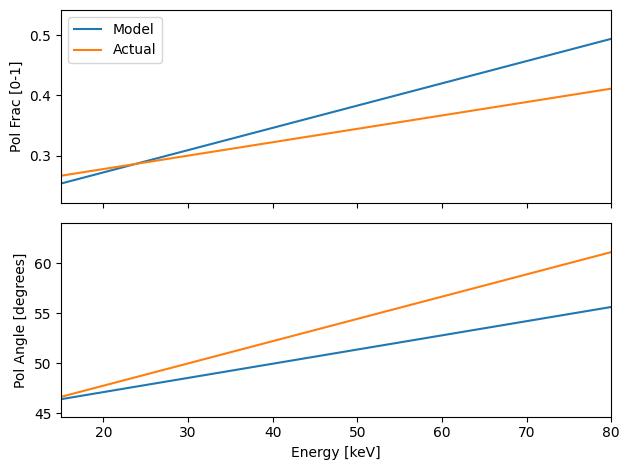

In [6]:
E = np.arange(10,90,1)
%matplotlib inline
fig,ax = plt.subplots(2,1,sharex = True)
ax[0].plot(E,polfrac_model(E,res.x[2],res.x[3]),label='Model')
ax[0].plot(E,polfrac_model(E,PD_30,PD_slope),label='Actual')
ax[0].set_xlim(15,80)
ax[0].set_ylabel("Pol Frac [0-1]")
ax[1].set_xlabel("Energy [keV]")
ax[1].plot(E,polang_model(E,res.x[0],res.x[1]))
ax[1].plot(E,polang_model(E,PA_30,PA_slope))
ax[1].set_ylabel("Pol Angle [degrees]")
#ax[0].set_ylim(0,1)
ax[0].legend()
fig.tight_layout()

## Test Code for adding Background

## Error Calculations


In [7]:

def get_errors(par,index,error_step):
    par = par.copy()
    par2 = par.copy()
    start = time.time()
    value = res.fun
    error = 0
    par[index]
    #get the error values by incrememnting PA/PD until we get a change in the log likelihood of 1.
    while abs(res.fun - value) < 1:
        if abs(res.fun - value) < 0.25:
            error += error_step*5
        else: 
            error += error_step
        par2[index] = par[index]+error
        value = multiprocessing_likelihoodfnc(par2)
    error -= 5*error_step
    while abs(res.fun - value) < 1:
        error += error_step/10
        par2[index] = par[index]+error
        value = multiprocessing_likelihoodfnc(par2)
    end = time.time()
    print(end-start)
    if error == 0:
        print("smaller error on index {index}")
        error += get_errors(par,index,error_step/10)
    return error

par0e = get_errors(res.x,0,0.1)
par2e = get_errors(res.x,2,0.0001)
if not fitConst:
    par1e = get_errors(res.x,1,0.0001)
    par3e = get_errors(res.x,3,0.00001)
else:
    par1e = 0
    par3e = 0

upperbounds = [res.x[0]+par0e,res.x[1]+par1e,res.x[2]+par2e,res.x[3]+par3e]
lowerbounds = [res.x[0]-par0e,res.x[1]-par1e,res.x[2]-par2e,res.x[3]-par3e]



5.170498609542847
81.05939817428589
499.6814467906952
59.892269134521484


In [8]:
print(upperbounds-res.x)     

[0.9     0.1061  0.0327  0.00175]


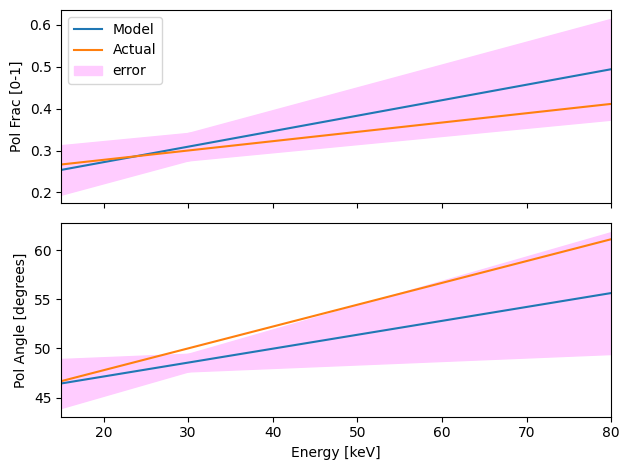

In [9]:
E = np.arange(15,81,1)
%matplotlib inline
fig,ax = plt.subplots(2,1,sharex = True)
ax[0].plot(E,polfrac_model(E,res.x[2],res.x[3]),label='Model')
ax[0].plot(E,polfrac_model(E,PD_30,PD_slope),label='Actual')
ax[0].fill_between(E,polfrac_model(E,lowerbounds[2],lowerbounds[3]),polfrac_model(E,upperbounds[2],upperbounds[3]),label='error',color='#ffccff')
ax[0].fill_between(E,polfrac_model(E,upperbounds[2],lowerbounds[3]),polfrac_model(E,lowerbounds[2],upperbounds[3]),color='#ffccff')

ax[0].set_ylabel("Pol Frac [0-1]")
ax[1].set_xlabel("Energy [keV]")
ax[0].set_xlim(15,80)
ax[1].plot(E,polang_model(E,res.x[0],res.x[1]))
ax[1].plot(E,polang_model(E,PA_30,PA_slope))
ax[1].fill_between(E,polang_model(E,lowerbounds[0],lowerbounds[1]),polang_model(E,upperbounds[0],upperbounds[1]),label='error',color='#ffccff')
ax[1].fill_between(E,polang_model(E,upperbounds[0],lowerbounds[1]),polang_model(E,lowerbounds[0],upperbounds[1]),color='#ffccff')
ax[1].set_ylabel("Pol Angle [degrees]")
ax[0].legend()
fig.tight_layout()
fig.savefig('/home/jacob/Energy_dep_polarization_plots_realspec_withE.pdf')


In [10]:
print(upperbounds-res.x)
print(abs(lowerbounds-res.x))

[0.9     0.1061  0.0327  0.00175]
[0.9     0.1061  0.0327  0.00175]


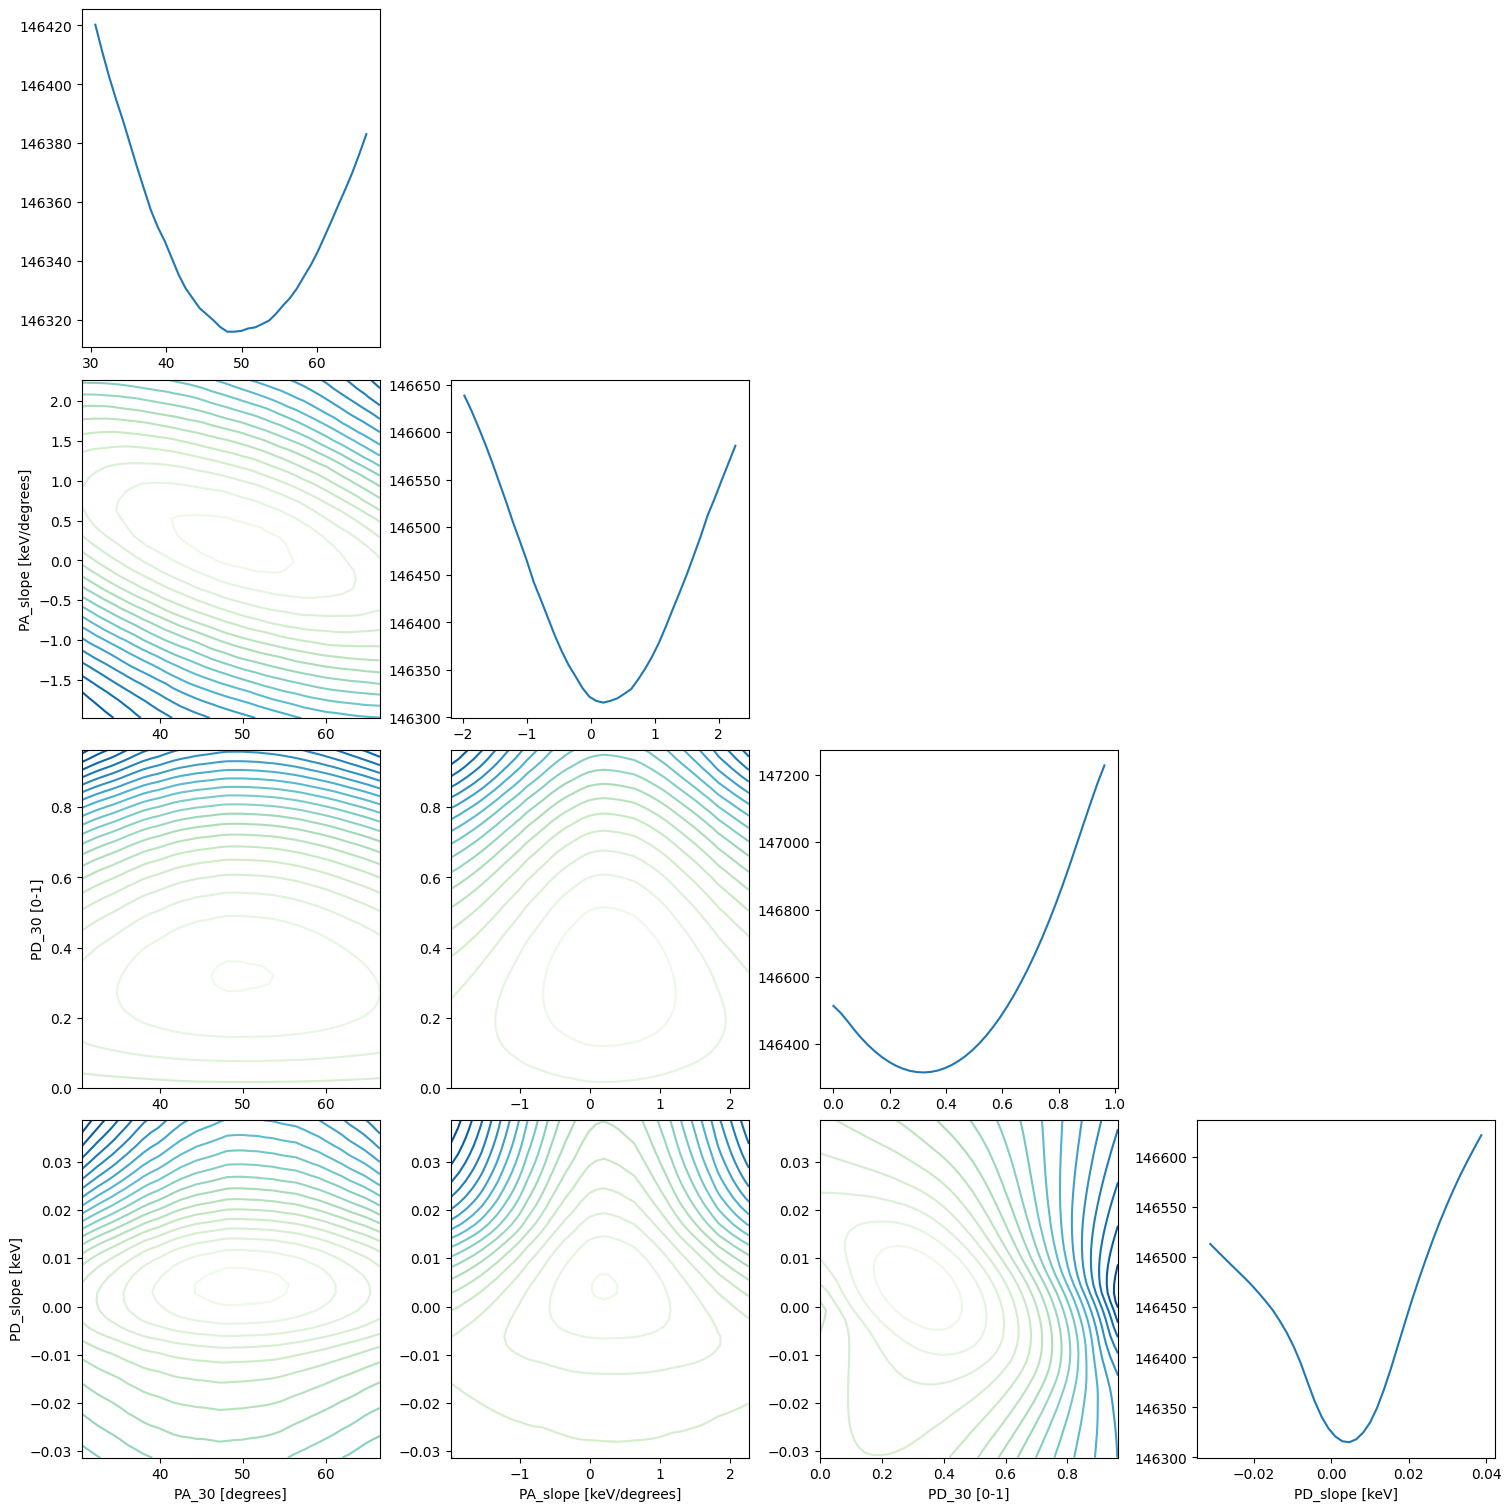

In [14]:
p = res.x.copy()
steps = 40
width = 20
if par1e == 0:
    par1e = get_errors(res.x,1,0.0001)
    par3e = get_errors(res.x,3,0.00001)
pas_ = np.linspace(p[0] - (par0e*width),p[0] + (par0e*width),steps)
pd_ = np.linspace(p[2] - (par2e*width),p[2] + (par2e*width),steps)
#pd_ = np.linspace(0.50,0.75,steps)
if pd_.max() > 1:
    pd_ = np.linspace(p[2] - (par2e*width),0.75,steps)
    pdmax = 0.75
else:
    pdmax = p[2] + (par2e*width)
if pd_.min() < 0:
    pd_ = np.linspace(0,pdmax,steps)
paslopes_ = np.linspace(p[1] - (par1e*width),p[1] + (par1e*width), steps)
pdslopes_ = np.linspace(p[3] - (par3e*width),p[3] + (par3e*width), steps)
arrays = [pas_,paslopes_,pd_,pdslopes_]
titles = ['PA_30 [degrees]','PA_slope [keV/degrees]' , 'PD_30 [0-1]', 'PD_slope [keV]' ]
fig,ax = plt.subplots(4,4,figsize=(15, 15),layout="constrained",sharex=False,sharey=False)
for i in np.arange(4):
    for j in np.arange(4):
        #print(i,j)
        par = list(res.x.copy())
        if j < i:
            
            X,Y = np.meshgrid(arrays[i],arrays[j])
            Z = np.empty_like(X)
            for k in np.arange(len(arrays[i])):
                for l in np.arange(len(arrays[j])):
                    par[i] = arrays[i][k]
                    par[j] = arrays[j][l]
                    Z[k,l] = multiprocessing_likelihoodfnc(par)
            ax[i,j].contour(Y,X,Z.T,20,cmap='GnBu')
            #ax[i,j].set_xlim(arrays[i].min(),arrays[i].max())
            #ax[i,j].set_ylim(arrays[j].min(),arrays[j].max())
            #ax[i,j].colorbar()
            if i == 3:
                ax[i,j].set_xlabel(titles[j])
            if j == 0:
                ax[i,j].set_ylabel(titles[i])
            #if i != 0:
            #    ax[i,j].tick_params(labelleft=None)
            #if j != 0:
            #    ax[i,j].tick_params(labelbottom=None)
        elif i == j:
            Z = []
            for k in np.arange(len(arrays[i])):
                par[i] = arrays[i][k]
                Z = np.append(Z,multiprocessing_likelihoodfnc(par))
            ax[i,j].plot(arrays[i][:],Z)
            #ax[i,j].tick_params(labelleft=None)
            if i == 3 :
                ax[i,j].set_xlabel(titles[j])
        else:
            ax[i,j].axis('off')
            continue
fig.savefig("/home/jacob/PolarizationLikelihoodErrors_realspec_smallPD.pdf")
#plt.show()


## Pixel Column Likelihood Distributions

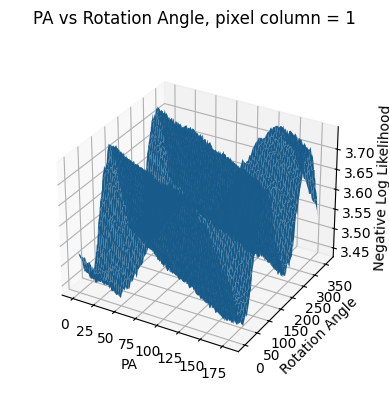

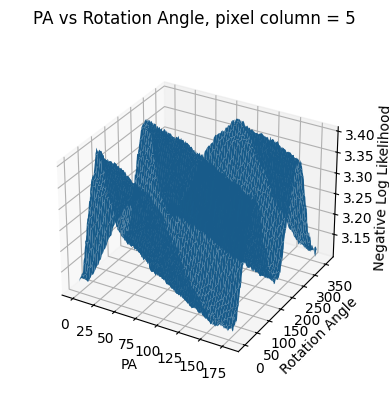

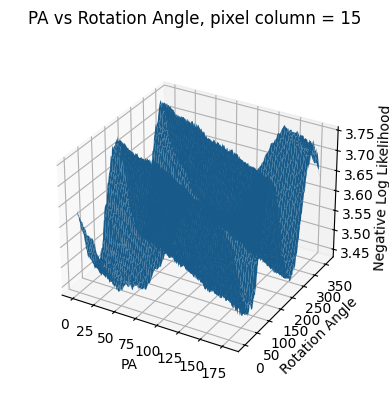

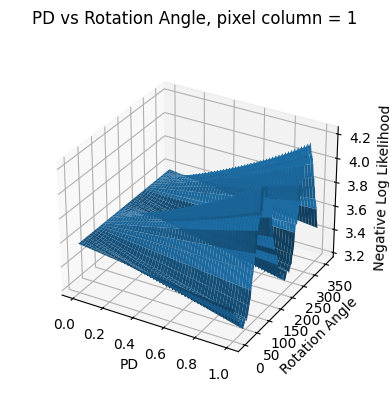

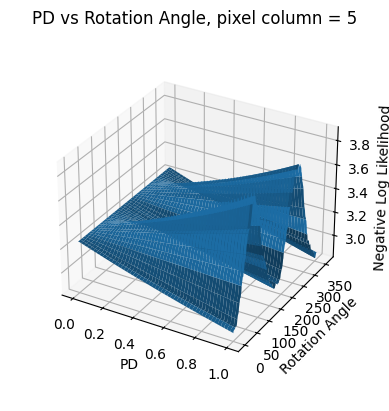

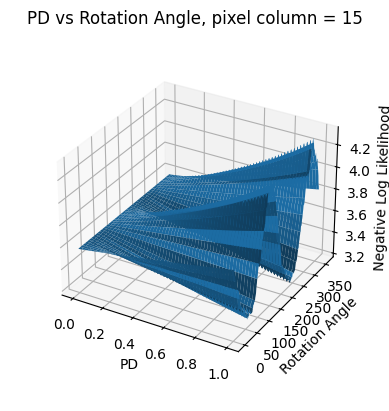

In [12]:
pixels=[1,5,15]
PA = np.linspace(0,180,180*3)
PD = np.linspace(0,1,100*3)
RA = np.linspace(0,359,360,dtype='int')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cbook, cm

#pars = [50,20/90,0.3,0.2/90]
pars = res.x.copy()
def pixel_likelihood_plots(pixels,ra,pa,index,opt_values):
    array = opt_values.copy()
    for i in pixels:
            X,Y = np.meshgrid(pa,ra)
            Z = np.empty_like(X)
            array[0] = i
            
            for k in range(len(ra)):
                array[3] = ra[k]
                
                for l in range(len(pa)):
                    array[index] = pa[l]
                    z1 = full_likelihood_tensor[int(np.ceil(i-1)),int(np.floor(array[1])),int(np.ceil(array[2]*100)),int(array[3])]
                    z2 = full_likelihood_tensor[int(np.ceil(i-1)),int(np.ceil(array[1])),int(np.ceil(array[2]*100)),int(array[3])]
    
                    z3 = full_likelihood_tensor[int(np.ceil(i-1)),int(np.ceil(array[1])),int(np.floor(array[2]*100)),int(array[3])]
                    z4 = full_likelihood_tensor[int(np.ceil(i-1)),int(np.floor(array[1])),int(np.floor(array[2]*100)),int(array[3])]

                    # Using the 4 nearest Polarization points, using the distance from them to the expected point as the weight, weight the likelihoods
                    dx1 = int(np.floor(array[1])) - array[1]
                    dy1 = int(np.ceil(array[2]*100)) - (array[2]*100)
                    a = 1/np.hypot(dx1,dy1)
                
                    dx2 = int(np.ceil(array[1])) - array[1]
                    dy2 = int(np.ceil(array[2]*100)) - (array[2]*100)
                    b = 1/np.hypot(dx2,dy2)
    
                    dx3 = int(np.ceil(array[1])) - array[1]
                    dy3 = int(np.floor(array[2]*100)) - (array[2]*100)
                    c = 1/np.hypot(dx3,dy3)
                
                    dx4 = int(np.floor(array[1])) - array[1]
                    dy4 = int(np.floor(array[2]*100)) - (array[2]*100)
                    d = 1/np.hypot(dx4,dy4)
                
                    # weigh likelihoods with 1/hypot
                    likelihood = ((a*z1)+(b*z2)+(c*z3)+(d*z4))/(a+b+c+d)
                    Z[k,l] = -np.log(likelihood)

        
            fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

            #ls = LightSource(270, 45)

            #rgb = ls.shade(Z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
            
            surf = ax.plot_surface(X, Y, Z)#, rstride=1, cstride=1,facecolors=rgb)
                           #linewidth=0, antialiased=False, shade=True)
            attribute_list = ['Pixel','PA','PD','RA']
            ax.set_zlabel('Negative Log Likelihood')
            ax.set_xlabel(f"{attribute_list[index]}")
            ax.set_ylabel('Rotation Angle')
            ax.set_box_aspect(None, zoom=0.85)
            ax.set_title(f"{attribute_list[index]} vs Rotation Angle, pixel column = {i}")
            plt.savefig(f"/home/jacob/Likelihood_plots/Pixel_{i}_{attribute_list[index]}.pdf")

pixel_likelihood_plots(pixels,RA,PA,1,pars)
pixel_likelihood_plots(pixels,RA,PD,2,pars)

## Stoke's Analysis

In [13]:
energy = data_set['energy']
constant_model = res.x.copy()
sim_model = [PA_30,PA_slope,PD_30,PD_slope]

def get_stokes(par,energy):
    PA = polang_model(energy,par[0],par[1])
    PD = polfrac_model(energy,par[2],par[3])

    U = PD*np.sin(2*PA*np.pi/180)
    Q = PD*np.cos(2*PA*np.pi/180)
    U_I = U.sum()/len(energy)
    Q_I = Q.sum()/len(energy)

    return U_I,Q_I



U,Q = get_stokes(sim_model,energy)
U2,Q2 = get_stokes(constant_model,energy)
table = [[U,Q,0.5*np.arctan2(U,Q)*180/np.pi,np.sqrt((U**2) + (Q**2))],[U2,Q2,0.5*np.arctan2(U2,Q2)*180/np.pi,np.sqrt((U2**2) + (Q2**2))]]
table = pd.DataFrame(table,columns=['U','Q','recalculated PA','recalculated PD'],index=['Sim Model','Fit Model'])
display(table)
PD = np.sqrt((U**2) + (Q**2))
PA = 0.5*np.arctan2(U,Q)*180/np.pi
print(1/np.sqrt(2*len(energy)))



,U,Q,recalculated PA,recalculated PD
Sim Model,0.30564523323744813,-0.07689352216422832,52.060644768266535,0.3151691963875828
Fit Model,0.3318750569453845,-0.05836463380456995,49.987115306170615,0.3369680754932784


0.0029457413197841384


## Old But potentially useful code